In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

Simple logistic regression

In [39]:
data = pd.read_csv('data/ML_DATA_MXF.csv')
data.dropna(inplace= True)

#remove line below to train on samples rather than mutations
data.drop_duplicates(subset=['GENE_MUTATION'], keep='first', inplace=True)
data.GENE_MUTATION.value_counts()

GENE_MUTATION
gyrA_D94G     1
gyrA_A322E    1
gyrA_H334Y    1
gyrB_K452N    1
gyrB_G598E    1
             ..
gyrA_T267I    1
gyrB_D461N    1
gyrA_S237P    1
gyrB_S576T    1
gyrB_G594R    1
Name: count, Length: 145, dtype: int64

In [40]:
data.CLEAN_BINARY_PHENOTYPE.value_counts()

CLEAN_BINARY_PHENOTYPE
S    126
R     19
Name: count, dtype: int64

In [41]:
data

,index,DRUG,MIC,LOG2MIC,BINARY_PHENOTYPE,PHENOTYPE_QUALITY,GENE,POSITION,GENE_MUTATION,CLEAN_BINARY_PHENOTYPE,...,T,SASA,snap2_score,snap2_accuracy,dist_MGB,dist_MGE,dist_drug,temp_factor,depth,deep_ddG
0,0,MXF,2.0,1.00,R,HIGH,gyrA,94.0,gyrA_D94G,R,...,False,88.155089,63.0,80.0,18.494689,7.838828,14.503318,46.660000,1.733342,-0.873
1,1,MXF,4.0,2.00,R,HIGH,gyrA,90.0,gyrA_A90V,R,...,False,55.555816,-64.0,82.0,14.434102,5.483332,10.609526,40.439999,1.665078,0.089
2,2,MXF,>4,3.00,R,MEDIUM,gyrA,94.0,gyrA_D94N,R,...,False,88.155089,56.0,75.0,18.494689,7.838828,14.503318,46.660000,1.733342,-0.347
7,7,MXF,1.0,0.00,S,HIGH,gyrA,94.0,gyrA_D94A,R,...,False,88.155089,46.0,71.0,18.494689,7.838828,14.503318,46.660000,1.733342,-0.421
8,8,MXF,0.5,-1.00,S,HIGH,gyrB,500.0,gyrB_T500N,S,...,False,91.708157,-69.0,82.0,20.980382,18.433229,12.209730,63.970001,1.544689,0.026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,1540,MXF,0.25,-2.00,S,HIGH,gyrA,489.0,gyrA_R489S,S,...,False,182.599090,-26.0,61.0,42.680690,36.467443,43.033351,76.720001,1.555280,-0.201
1568,1568,MXF,<=0.06,-4.06,S,HIGH,gyrA,211.0,gyrA_D211G,S,...,False,89.994120,-73.0,87.0,46.169375,46.449204,50.519658,77.099998,1.573314,-0.675
1573,1573,MXF,0.12,-3.06,S,HIGH,gyrA,108.0,gyrA_P108S,S,...,True,38.846677,26.0,63.0,29.922430,21.820593,28.409331,40.820000,1.914608,-1.514
1608,1608,MXF,0.25,-2.00,S,HIGH,gyrB,607.0,gyrB_I607V,S,...,False,53.472410,-48.0,72.0,18.912597,31.286287,31.017459,72.449997,1.896893,-0.628


In [42]:
true_label = data.CLEAN_BINARY_PHENOTYPE

features = ['d_volume', 'd_hydropathy_KD', 'd_hydropathy_WW',
       'd_MW', 'd_Pi', 'secondary_structure', 'phi', 'psi', 'residue_sasa', 
       'n_hbond_acceptors', 'n_hbond_donors', 'SASA', 'snap2_score', 'dist_MGB', 'dist_MGE', 'dist_drug', 'temp_factor', 'depth', 'deep_ddG'] # 'B', 'C', 'E', 'G', 'H', 'T',

features = data[features]
features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
features.drop('secondary_structure', inplace = True, axis = 1)

true_label
features

/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_9295/2563246430.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_9295/2563246430.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop('secondary_structure', inplace = True, axis = 1)


,d_volume,d_hydropathy_KD,d_hydropathy_WW,d_MW,d_Pi,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,dist_MGB,dist_MGE,dist_drug,temp_factor,depth,deep_ddG,secondary_structure_codes
0,-51.0,3.1,-1.27,-58.0,3.20,-58.04,-41.61,97.4,1.0,1.0,88.155089,63.0,18.494689,7.838828,14.503318,46.660000,1.733342,-0.873,0
1,51.4,2.4,-0.86,28.0,-0.04,-61.83,-59.76,47.0,2.0,0.0,55.555816,-64.0,14.434102,5.483332,10.609526,40.439999,1.665078,0.089,0
2,3.0,0.0,-1.98,-1.0,2.64,-58.04,-41.61,97.4,1.0,1.0,88.155089,56.0,18.494689,7.838828,14.503318,46.660000,1.733342,-0.347,0
7,-22.5,5.3,-2.08,-44.0,3.23,-58.04,-41.61,97.4,1.0,1.0,88.155089,46.0,18.494689,7.838828,14.503318,46.660000,1.733342,-0.421,0
8,-2.0,-2.8,0.32,13.0,-0.19,-57.87,-37.74,88.7,1.0,0.0,91.708157,-69.0,20.980382,18.433229,12.209730,63.970001,1.544689,0.026,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,-84.4,3.7,-0.67,-69.1,-5.08,-82.97,-45.35,183.0,0.0,2.0,182.599090,-26.0,42.680690,36.467443,43.033351,76.720001,1.555280,-0.201,0
1568,-51.0,3.1,-1.27,-58.0,3.20,-72.23,178.12,94.3,1.0,0.0,89.994120,-73.0,46.169375,46.449204,50.519658,77.099998,1.573314,-0.675,2
1573,-23.7,0.8,0.64,-10.0,-0.62,-50.85,138.42,37.4,0.0,0.0,38.846677,26.0,29.922430,21.820593,28.409331,40.820000,1.914608,-1.514,3
1608,-26.7,-0.3,0.28,-14.1,-0.06,-95.25,108.88,53.5,0.0,0.0,53.472410,-48.0,18.912597,31.286287,31.017459,72.449997,1.896893,-0.628,1


In [43]:
random_seed = 144

X_train,X_test,y_train,y_test=train_test_split(features, true_label, test_size=0.30, random_state = random_seed) 

In [44]:
len(X_test)

44

In [45]:
random_seed = 144

folds = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)

param_grid = [ 
                {   'penalty': ['l2'],
                    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 
                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'class_weight' : ['balanced', None]
                } 
            ]


In [46]:
gsvc = GridSearchCV(LogisticRegression(random_state=random_seed), param_grid, cv = folds, scoring = ['recall', 'roc_auc', 'precision'], refit = 'recall') #, scoring='f1' , scoring = 'recall'
gsvc.fit(X_train,y_train)
gsvc.cv_results_

/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 21

{'mean_fit_time': array([0.01827416, 0.00945497, 0.00282297, 0.00518341, 0.00463543,
        0.00451951, 0.01745553, 0.00840273, 0.00221171, 0.00394106,
        0.00508494, 0.0040308 , 0.01674623, 0.01227808, 0.0025558 ,
        0.00396886, 0.00416565, 0.00449986, 0.019906  , 0.01268482,
        0.00229492, 0.00382342, 0.00391917, 0.00480056, 0.02461548,
        0.01271262, 0.00245223, 0.00403843, 0.00429611, 0.00477509,
        0.02501974, 0.01190276, 0.00280852, 0.0050159 , 0.00417919,
        0.00728674, 0.03398046, 0.01183505, 0.00266733, 0.00515313,
        0.00435948, 0.00417385, 0.03014193, 0.01106091, 0.00245819,
        0.00478635, 0.00416884, 0.00401316, 0.03779783, 0.01216731,
        0.00378032, 0.0048183 , 0.00413375, 0.00431495, 0.03836079,
        0.01358342, 0.00257492, 0.00462499, 0.00425692, 0.00403271,
        0.04615974, 0.01255221, 0.00339351, 0.00528417, 0.00429087,
        0.00421433, 0.03851886, 0.01239433, 0.00282412, 0.00505142,
        0.00397682, 0.00427761,

In [47]:
#gsvc = 

In [48]:
df = pd.DataFrame(gsvc.cv_results_)
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_class_weight', 'param_penalty', 'param_solver',
       'params', 'split0_test_recall', 'split1_test_recall',
       'split2_test_recall', 'split3_test_recall', 'split4_test_recall',
       'mean_test_recall', 'std_test_recall', 'rank_test_recall',
       'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc',
       'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc',
       'std_test_roc_auc', 'rank_test_roc_auc', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision'],
      dtype='object')

In [49]:
gsvc.best_params_

{'C': 0.001,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [50]:
gsvc.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', random_state=144,
                   solver='newton-cg')

In [51]:
logreg =  LogisticRegression(solver='newton-cg', random_state=random_seed, class_weight = 'balanced', C = 0.001, penalty = 'l2') 

In [52]:
logreg.fit(X_train,y_train) 

LogisticRegression(C=0.001, class_weight='balanced', random_state=144,
                   solver='newton-cg')

In [53]:
y_pred=logreg.predict(X_test) 

In [54]:
y_df = pd.DataFrame(y_pred)
y_df.value_counts()

S    36
R     8
Name: count, dtype: int64

In [55]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

cnf_matrix 

array([[ 3,  1],
       [ 5, 35]])

Text(0.5, 427.9555555555555, 'Predicted label')

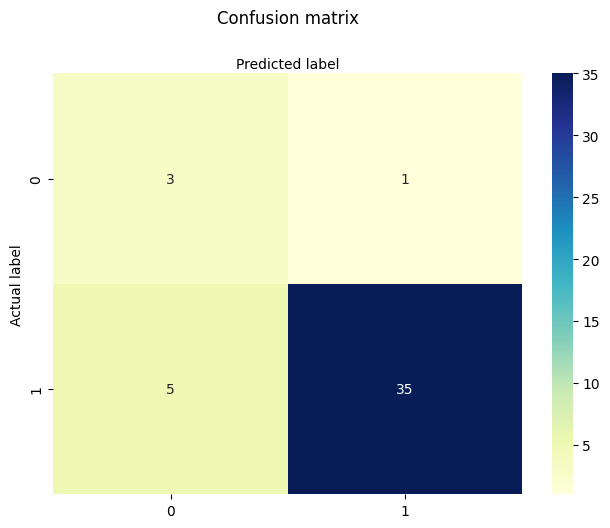

In [56]:
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 

tick_marks = np.arange(len(class_names)) 

plt.xticks(tick_marks, class_names) 

plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 

plt.ylabel('Actual label') 

plt.xlabel('Predicted label')

In [57]:
sensitivity = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
specificity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print(sensitivity, specificity)

0.875 0.75
